<a href="https://colab.research.google.com/github/cserock/colab-examples/blob/main/05_One_hot_encoding_Word_Embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# One-hot encoding / Word Embedding

## 1. One-hot encoding

한국어 자연어 처리를 위해 코엔엘파이 패키지를 설치합니다.

In [3]:
!apt-get update
!apt-get install openjdk-11-jdk

Hit:1 https://cli.github.com/packages stable InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ Packages [83.2 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,288 kB]
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [6,148 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,411 kB]
Hit:14 htt

In [4]:
!readlink -f $(which java)

/usr/lib/jvm/java-11-openjdk-amd64/bin/java


In [5]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["PATH"] += ":/usr/lib/jvm/java-11-openjdk-amd64/bin"


In [6]:
!pip install konlpy

코엔엘파이의 Okt 형태소 분석기를 통해서 우선 문장에 대해서 토큰화를 수행

In [7]:
from konlpy.tag import Okt
okt = Okt()
token = okt.morphs("나는 딥러닝을 배운다")
print(token)

['나', '는', '딥', '러닝', '을', '배운다']


각 토큰에 대해서 고유한 인덱스(index)를 부여합니다. 지금은 문장이 짧기 때문에 각 단어의 빈도수를 고려하지 않지만, 빈도수 순대로 단어를 정렬하여 고유한 인덱스를 부여하는 작업이 사용되기도 합니다. (정수 인코딩 챕터 참고)

In [ ]:
word2index = {}
for voca in token:
     if voca not in word2index.keys():
       word2index[voca] = len(word2index)
print(word2index)

{'나': 0, '는': 1, '딥': 2, '러닝': 3, '을': 4, '배운다': 5}


토큰을 입력하면 해당 토큰에 대한 원-핫 벡터를 만들어내는 함수 작성

In [ ]:
def one_hot_encoding(word, word2index):
  one_hot_vector = [0]*(len(word2index))
  index = word2index[word]
  one_hot_vector[index] = 1
  return one_hot_vector

In [ ]:
one_hot_encoding("러닝",word2index)

[0, 0, 0, 1, 0, 0]

## 2. 한국어 Word2Vec 만들기(네이버 영화 리뷰)
네이버 영화 리뷰 데이터로 한국어 Word2Vec을 만들어봅시다.

In [ ]:
!pip install gensim konlpy tqdm

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from gensim.models.word2vec import Word2Vec
from konlpy.tag import Okt

네이버 영화 리뷰 데이터를 다운로드합니다.

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")

('ratings.txt', <http.client.HTTPMessage at 0x7c3eff9c1250>)

네이버 영화 리뷰 데이터를 데이터프레임으로 로드하고 상위 5개의 행을 출력해봅시다.

In [ ]:
train_data = pd.read_table('ratings.txt')
train_data[:5] # 상위 5개 출력

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,"디자인을 배우는 학생으로, 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산...",1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1


In [ ]:
# 리뷰 개수 출력
print(len(train_data))

200000


In [ ]:
# NULL 값 존재 유무
print(train_data.isnull().values.any())

True


In [ ]:
# 결측값이 존재하므로 결측값이 존재하는 행을 제거합니다.
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인


False


결측값이 삭제된 후의 리뷰 개수를 확인합니다.

In [ ]:
print(len(train_data)) # 리뷰 개수 출력


199992


총 199,992개의 리뷰가 존재합니다. 정규 표현식을 통해 한글이 아닌 경우 제거하는 전처리를 진행합니다.

In [ ]:
# 정규 표현식을 통한 한글 외 문자 제거
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","", regex=True)


In [ ]:
# 상위 5개 출력
train_data[:5]

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
1,8132799,디자인을 배우는 학생으로 외국디자이너와 그들이 일군 전통을 통해 발전해가는 문화산업...,1
2,4655635,폴리스스토리 시리즈는 부터 뉴까지 버릴께 하나도 없음 최고,1
3,9251303,와 연기가 진짜 개쩔구나 지루할거라고 생각했는데 몰입해서 봤다 그래 이런게 진짜 영화지,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화,1


학습 시에 사용하고 싶지 않은 단어들인 불용어를 제거하겠습니다. 형태소 분석기 Okt를 사용하여 각 문장에 대해서 일종의 단어 내지는 형태소 단위로 나누는 토큰화를 수행합니다. 다소 시간이 소요될 수 있습니다.

In [ ]:
from tqdm import tqdm

# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 형태소 분석기 OKT를 사용한 토큰화 작업 (다소 시간 소요)
okt = Okt()

tokenized_data = []
for sentence in tqdm(train_data['document']):
    tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    stopwords_removed_sentence = [word for word in tokenized_sentence if not word in stopwords] # 불용어 제거
    tokenized_data.append(stopwords_removed_sentence)

100%|██████████| 199992/199992 [09:41<00:00, 343.83it/s]


토큰화가 된 상태에서는 각 리뷰의 길이 분포 또한 확인이 가능합니다.

리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 10.716703668146726


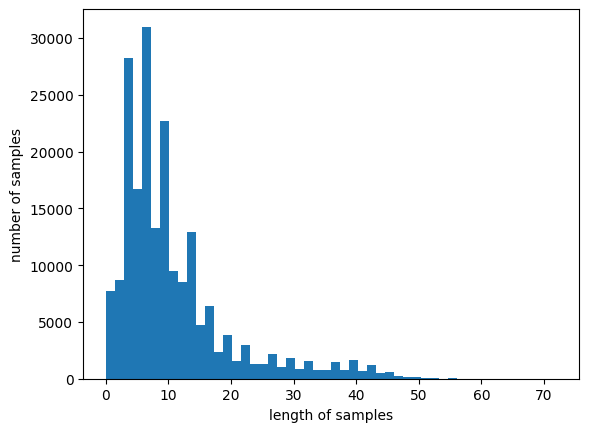

In [ ]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(review) for review in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(review) for review in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

Word2Vec으로 토큰화 된 네이버 영화 리뷰 데이터를 학습합니다.

In [ ]:
from gensim.models import Word2Vec

model = Word2Vec(sentences = tokenized_data, vector_size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

학습이 다 되었다면 Word2Vec 임베딩 행렬의 크기를 확인합니다.

In [ ]:
# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape


(16477, 100)

총 16,477개의 단어가 존재하며 각 단어는 100차원으로 구성되어져 있습니다. '재난영화'와 유사한 단어들을 뽑아봅시다.

In [ ]:
print(model.wv.most_similar("재난영화"))

[('공포물', 0.8451089859008789), ('전쟁영화', 0.822053849697113), ('중국영화', 0.8039650917053223), ('느와르', 0.7896471619606018), ('호러물', 0.7865666151046753), ('로코', 0.7801953554153442), ('액션영화', 0.7759423851966858), ('애니매이션', 0.7739637494087219), ('만화영화', 0.7690702676773071), ('스릴러물', 0.7649336457252502)]


'멜로'와 유사한 단어들을 뽑아봅시다.

In [ ]:
print(model.wv.most_similar("멜로"))


[('로맨스', 0.8708440661430359), ('스릴러', 0.8435184955596924), ('호러', 0.8373156785964966), ('판타지', 0.8354811668395996), ('코메디', 0.8311426043510437), ('코미디', 0.8117967844009399), ('느와르', 0.811713695526123), ('무협', 0.8037664890289307), ('로맨틱', 0.799096405506134), ('히어로', 0.7959489226341248)]
